In [1]:
import os
from PIL import Image
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import tifffile as tiff
import numpy as np
import pandas as pd
import cv2
from sklearn.metrics import mean_absolute_error, accuracy_score
import random
from skimage.filters import threshold_multiotsu
import tifffile as tiff
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Define the directory containing the images
#test_image = "BPS-Microscopy/DAPI_MASK_images"
image_dir = "BPS-Microscopy/train"

# List to store image sizes
image_sizes = []

#Number of train images
#Total number of images: 77178
#Number of DAPI images: 77177

#Results for DAPI_MASK_images
# Total number of images: 171505
# Number of DAPI images: 85752


2024-10-18 13:44:20.907392: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-18 13:44:20.933989: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-18 13:44:20.934025: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-18 13:44:20.956659: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-18 13:44:22.005239: W tensorflow/compiler/tf

2024-10-18 13:44:24.809317: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: UNKNOWN ERROR (100)


(256, 256, 1)
Min value: 0.0, Max value: 1.0 TF
(256, 256, 1)
Min value: 202.0, Max value: 972.0 tiff


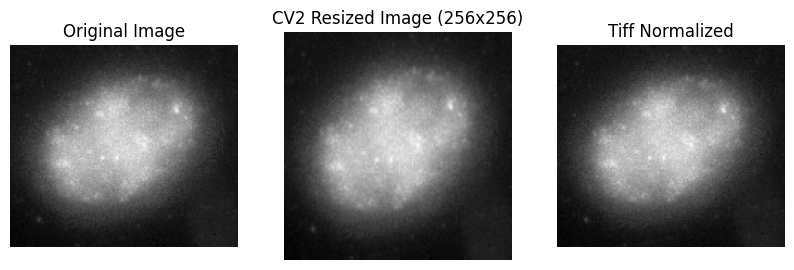

In [2]:
# Function to load and preprocess image
def load_image_cv2(file_path, target_size=None):
    # Load the image using cv2
    image = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)
    original = image
    
    # Convert the image to a tensor
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    # original = image
    
    # Ensure the image has 3 dimensions (height, width, channels)
    if image.ndim == 2:
        image = tf.expand_dims(image, axis=-1)  # Add the channel dimension
    # original = image

    # Resize the image
    # image = tf.image.resize_with_pad(image, target_size[0], target_size[1], method=tf.image.ResizeMethod.GAUSSIAN)
    image = tf.image.resize(image, target_size)
    
    # Normalize the image to [0, 1]
    image = (image - tf.reduce_min(image)) / (tf.reduce_max(image) - tf.reduce_min(image))

    print(image.shape)
    min_val = np.min(image)
    max_val = np.max(image)
    print(f"Min value: {min_val}, Max value: {max_val}", 'TF')
    
    return image, original

# Define the directory containing the images
#imager_dir = "BPS-Microscopy/DAPI_MASK_images"
image_dir = "BPS-Microscopy/train"

# Get an example image path
# image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('_DAPI.tif')]
image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.tif')]
example_image_path = image_files[100]

# Load cv2 to tf image
target_size = (256, 256)  # Example target size
image_tensor, original = load_image_cv2(example_image_path, target_size)
print(image_tensor.shape)


# Load the image
tiff_image = tiff.imread(example_image_path)

# Function to normalize 16-bit image to 8-bit
def tiff_normalize_image(image):
    image = image.astype(np.float32)
    original = image
    min_val = np.min(image)
    max_val = np.max(image)
    print(f"Min value: {min_val}, Max value: {max_val}", 'tiff')
    
    # Normalize to [0, 1]
    image = (image - min_val) / (max_val - min_val)
    
    # Scale to [0, 255] and convert to uint8
    image = (image * 255).astype(np.uint8)
    
    return image

# Convert the image to 8-bit
tiff_normalized_image = tiff_normalize_image(tiff_image)


# Plot the original and resized images
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(original, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("CV2 Resized Image (256x256)")
plt.imshow(image_tensor[..., 0], cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Tiff Normalized")
plt.imshow(tiff_normalized_image, cmap='gray')
plt.axis('off')

plt.show()


In [3]:
# Load the metadata from the Excel file
# metadata_path = 'BPS-Microscopy/DAPI_MASK_images/meta_DAPI_MASK.csv'
metadata_path = 'BPS-Microscopy/train/meta.csv'
metadata = pd.read_csv(metadata_path)

# Set particle_type to None where dose_Gy is 0
metadata.loc[metadata['dose_Gy'] == 0, 'particle_type'] = 'Control'

# Display the first few rows of the metadata
print(metadata.head())


# print(metadata[metadata['dose_Gy'] == 0].head())

                               filename  dose_Gy particle_type  \
0  P242_73665006707-A6_003_013_proj.tif     0.82            Fe   
1  P242_73665006707-A6_008_034_proj.tif     0.82            Fe   
2  P242_73665006707-A6_009_007_proj.tif     0.82            Fe   
3  P242_73665006707-A6_009_031_proj.tif     0.82            Fe   
4  P242_73665006707-A6_009_038_proj.tif     0.82            Fe   

   hr_post_exposure  
0                 4  
1                 4  
2                 4  
3                 4  
4                 4  


Class distribution in 'particle_type':
particle_type
Control    27478
X-ray      26925
Fe         22774
Name: count, dtype: int64

Class percentage distribution in 'particle_type':
particle_type
Control    35.603872
X-ray      34.887337
Fe         29.508791
Name: count, dtype: float64

Distribution of 'dose_Gy':
dose_Gy
0.00    27478
0.10    13585
0.30     9250
0.82    13524
1.00    13340
Name: count, dtype: int64

Percentage distribution of 'dose_Gy':
dose_Gy
0.00    35.603872
0.10    17.602394
0.30    11.985436
0.82    17.523355
1.00    17.284942
Name: count, dtype: float64

Distribution of 'hr_post_exposure':
hr_post_exposure
4     27609
24    27198
48    22370
Name: count, dtype: int64

Percentage distribution of 'hr_post_exposure':
hr_post_exposure
4     35.773611
24    35.241069
48    28.985319
Name: count, dtype: float64


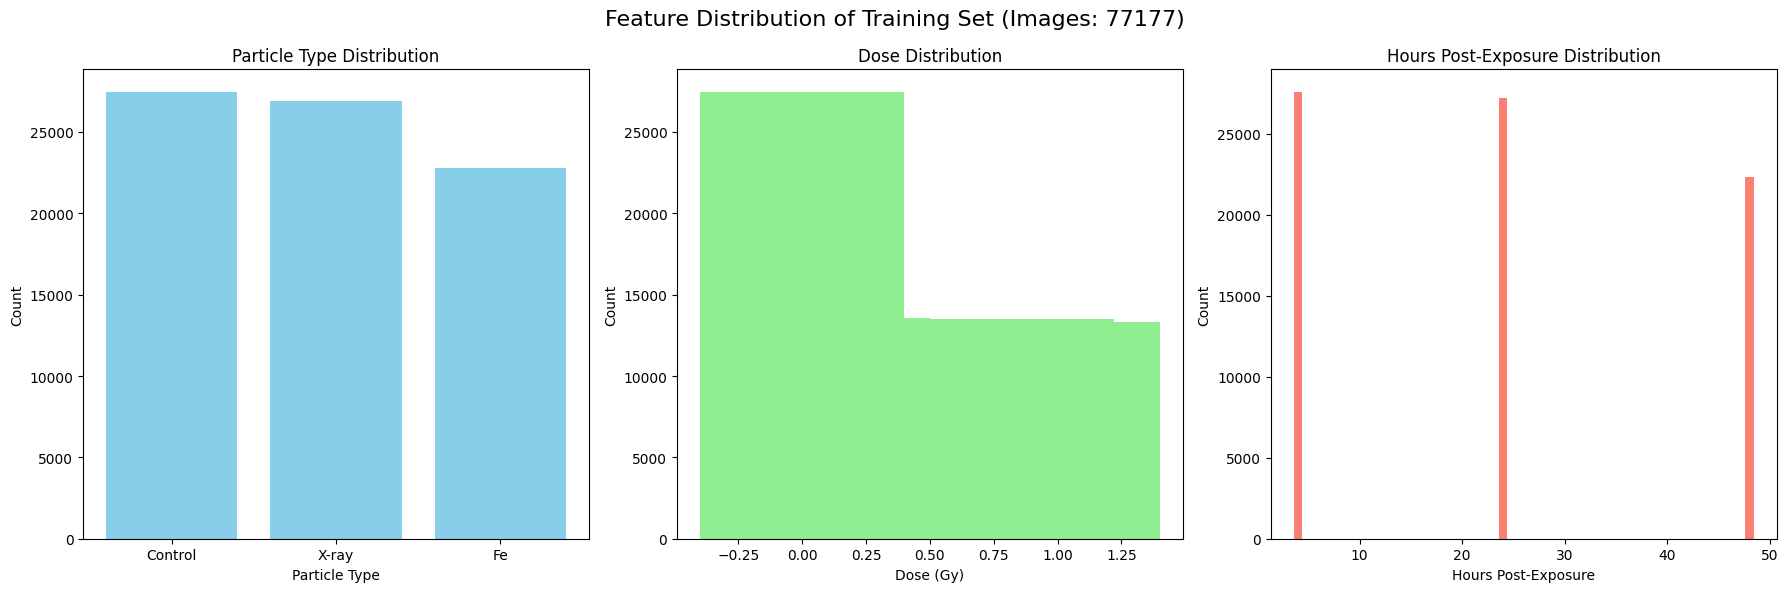

In [4]:
# Check for class imbalances in the 'particle_type' field
particle_type_counts = metadata['particle_type'].value_counts()
particle_type_percentages = particle_type_counts / len(metadata) * 100

print("Class distribution in 'particle_type':")
print(particle_type_counts)
print("\nClass percentage distribution in 'particle_type':")
print(particle_type_percentages)

# Check for distribution in the 'dose_Gy' field
dose_counts = metadata['dose_Gy'].value_counts().sort_index()
dose_percentages = dose_counts / len(metadata) * 100

print("\nDistribution of 'dose_Gy':")
print(dose_counts)
print("\nPercentage distribution of 'dose_Gy':")
print(dose_percentages)

# Check for distribution in the 'hr_post_exposure' field
hr_counts = metadata['hr_post_exposure'].value_counts().sort_index()
hr_percentages = hr_counts / len(metadata) * 100

print("\nDistribution of 'hr_post_exposure':")
print(hr_counts)
print("\nPercentage distribution of 'hr_post_exposure':")
print(hr_percentages)

# Plot the distributions for visualization
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Particle type distribution
axs[0].bar(particle_type_counts.index, particle_type_counts.values, color='skyblue')
axs[0].set_title('Particle Type Distribution')
axs[0].set_xlabel('Particle Type')
axs[0].set_ylabel('Count')

# Dose distribution
axs[1].bar(dose_counts.index, dose_counts.values, color='lightgreen')
axs[1].set_title('Dose Distribution')
axs[1].set_xlabel('Dose (Gy)')
axs[1].set_ylabel('Count')

# Hours post exposure distribution
axs[2].bar(hr_counts.index, hr_counts.values, color='salmon')
axs[2].set_title('Hours Post-Exposure Distribution')
axs[2].set_xlabel('Hours Post-Exposure')
axs[2].set_ylabel('Count')

# Add a super title for all three plots
fig.suptitle('Feature Distribution of Training Set (Images: 77177)', fontsize=16)

plt.tight_layout()
plt.show()



In [5]:
# Add the full path to the filenames in the metadata
metadata['filepath'] = metadata['filename'].apply(lambda x: os.path.join(image_dir, x))

# Filter only the valid DAPI images
# metadata = metadata[metadata['filename'].str.endswith('_DAPI.tif')]
metadata = metadata[metadata['filename'].str.endswith('.tif')]

# Display the first few rows of the updated metadata
metadata.head()


,filename,dose_Gy,particle_type,hr_post_exposure,filepath
0,P242_73665006707-A6_003_013_proj.tif,0.82,Fe,4,BPS-Microscopy/train/P242_73665006707-A6_003_0...
1,P242_73665006707-A6_008_034_proj.tif,0.82,Fe,4,BPS-Microscopy/train/P242_73665006707-A6_008_0...
2,P242_73665006707-A6_009_007_proj.tif,0.82,Fe,4,BPS-Microscopy/train/P242_73665006707-A6_009_0...
3,P242_73665006707-A6_009_031_proj.tif,0.82,Fe,4,BPS-Microscopy/train/P242_73665006707-A6_009_0...
4,P242_73665006707-A6_009_038_proj.tif,0.82,Fe,4,BPS-Microscopy/train/P242_73665006707-A6_009_0...


In [6]:
# import os
# import cv2

# def check_images_in_folder(folder_path):
#     for filename in os.listdir(folder_path):
#         if filename.endswith(".tif"):  # or any other valid image extension
#             image_path = os.path.join(folder_path, filename)
#             image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
            
#             if image is None or image.size == 0:
#                 print(f"Corrupt or empty image: {image_path}")
#             else:
#                 pass

# # Run the check on your image folder
# check_images_in_folder('BPS-Microscopy/train/')


In [7]:
# Load your metadata into a DataFrame
metadata_path = 'BPS-Microscopy/train/meta.csv'
metadata = pd.read_csv(metadata_path)

# Set particle_type to 'Control' where dose_Gy is 0
metadata.loc[metadata['dose_Gy'] == 0, 'particle_type'] = 'Control'

# Add the full path to the filenames in the metadata
image_dir = 'BPS-Microscopy/train/'  # Adjust as needed
metadata['filepath'] = metadata['filename'].apply(lambda x: os.path.join(image_dir, x))

# Filter only the valid TIFF images
metadata = metadata[metadata['filename'].str.endswith('.tif')]

# Map particle types to integers in the DataFrame (do this before balancing)
particle_type_mapping = {'Fe': 0, 'X-ray': 1, 'Control': 2}
metadata['particle_type_encoded'] = metadata['particle_type'].map(particle_type_mapping)

# Balancing classes and doses
sample_size = 60000
balanced_metadata = pd.DataFrame()

# Calculate the maximum number of samples per class combination
max_samples_per_class = sample_size // (len(metadata['dose_Gy'].unique()) * len(metadata['particle_type_encoded'].unique()))

for dose in metadata['dose_Gy'].unique():
    for particle_type in metadata['particle_type_encoded'].unique():
        subset = metadata[(metadata['dose_Gy'] == dose) & (metadata['particle_type_encoded'] == particle_type)]
        if len(subset) > max_samples_per_class:
            subset = subset.sample(max_samples_per_class)
        balanced_metadata = pd.concat([balanced_metadata, subset])

# Shuffle the balanced dataset
balanced_metadata = balanced_metadata.sample(frac=1).reset_index(drop=True)

# Extract the filenames used in the training set
train_filenames = set(balanced_metadata['filename'].values)

# Filter the full metadata to only include files not in the training set
non_train_metadata = metadata[~metadata['filename'].isin(train_filenames)]

# Randomly select one image from the non-training set
random_sample = non_train_metadata.sample(n=1, random_state=np.random.randint(0, 1000))

# Extract the image filepath, dose, and particle type for the selected image
image_path = random_sample['filename'].values[0]
dose_value = random_sample['dose_Gy'].values[0]
particle_type = random_sample['particle_type'].values[0]

# Ensure particle_type_encoded is in balanced_metadata
print(balanced_metadata.columns)  # This should include 'particle_type_encoded'

# # Define image loading function
# def load_image(image_path, target_size=(256, 256)):
#     image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
#     if image is None:
#         raise ValueError(f"Failed to load image at path: {image_path}")
#     image = tf.convert_to_tensor(image, dtype=tf.float32)
#     if image.ndim == 2:
#         image = tf.expand_dims(image, axis=-1)
#     image = tf.image.resize(image, target_size)
#     image = (image - tf.reduce_min(image)) / (tf.reduce_max(image) - tf.reduce_min(image))
#     return image
import cv2
import tensorflow as tf

import cv2
import tensorflow as tf

def load_image(image_path, target_size=(256, 256)):
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    
    if image is None or image.size == 0:
        print(f"Warning: Skipping invalid or empty image at path: {image_path}")
        return None
    
    if image.ndim == 3 and image.shape[2] != 1:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    
    if image.ndim == 2:
        image = tf.expand_dims(image, axis=-1)
    
    if image.shape[0] == 0 or image.shape[1] == 0:
        print(f"Warning: Image at path {image_path} has invalid dimensions. Skipping this image.")
        return None
    
    # Resize the image
    image = tf.image.resize(image, target_size)
    
    # Check dynamic range and issue a warning if necessary
    min_val = tf.reduce_min(image)
    max_val = tf.reduce_max(image)
    
    # Check if the min and max values are equal (i.e., no dynamic range)
    if tf.reduce_all(tf.equal(max_val, min_val)):
        print(f"Warning: Image at path {image_path} has no dynamic range (min = max). Skipping this image.")
        return None
    
    # Normalize the image
    image = (image - min_val) / (max_val - min_val)
    
    return image








# Define metadata processing function
def process_metadata(dose_Gy, particle_type):
    # particle_type is already an integer, no need to map it again
    max_dose = 1.0
    dose_Gy_normalized = dose_Gy / max_dose
    metadata_tensor = tf.convert_to_tensor([dose_Gy_normalized, particle_type], dtype=tf.float32)  # Use particle_type directly
    return metadata_tensor


# Define function to load image and metadata
def load_image_with_metadata(image_path, dose_Gy, particle_type, target_size=(256, 256)):
    image = load_image(image_path, target_size)
    metadata = process_metadata(dose_Gy, particle_type)
    return image, metadata

# Function to load data (removing decode call for particle_type)
def load_data(image_path, dose_Gy, particle_type):
    image_path = image_path.numpy().decode('utf-8')  # This is still needed for the filepath (string)
    dose_Gy = dose_Gy.numpy()  # Dose is a float
    # No need to decode particle_type as it's already an integer
    particle_type = particle_type.numpy()  
    
    image, metadata = load_image_with_metadata(image_path, dose_Gy, particle_type)
    return image, metadata


# Wrapper for tf.py_function
def load_data_wrapper(image_path, dose_Gy, particle_type):
    # Attempt to load the image
    image, _ = tf.py_function(func=load_data, inp=[image_path, dose_Gy, particle_type], Tout=[tf.float32, tf.float32])
    
    # If the image is None, skip this sample
    if image is None:
        return None, None
    
    # Ensure correct shape
    try:
        image.set_shape((256, 256, 1))
    except Exception as e:
        print(f"Shape issue with image at {image_path}: {e}")
        return None, None
    
    return image, {'dose_output': dose_Gy, 'particle_output': particle_type}





# Create a TensorFlow Dataset from the balanced DataFrame
dataset = tf.data.Dataset.from_tensor_slices((
    tf.constant(balanced_metadata['filepath'].values, dtype=tf.string),
    tf.constant(balanced_metadata['dose_Gy'].values, dtype=tf.float32),
    tf.constant(balanced_metadata['particle_type_encoded'].values, dtype=tf.int32)  # Use the encoded integer values
))

# Shuffle, map, and batch the dataset
dataset = dataset.shuffle(buffer_size=len(balanced_metadata)).map(load_data_wrapper).repeat().batch(32)

# Split your dataset into training and validation sets
train_size = int(0.8 * len(balanced_metadata))
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

# Output the values
print(f"Randomly selected image (not in training): {image_path}")
print(f"True Dose: {dose_value}")
print(f"True Particle Type: {particle_type}")


Index(['filename', 'dose_Gy', 'particle_type', 'hr_post_exposure', 'filepath',
       'particle_type_encoded'],
      dtype='object')
Randomly selected image (not in training): P282_73668608120-E5_012_006_proj.tif
True Dose: 0.0
True Particle Type: Control


In [8]:
# valid_images = 0
# for image, label in train_dataset:
#     if image is not None:
#         valid_images += 1

# print(f"Total valid images: {valid_images}")


<Figure size 1200x600 with 0 Axes>

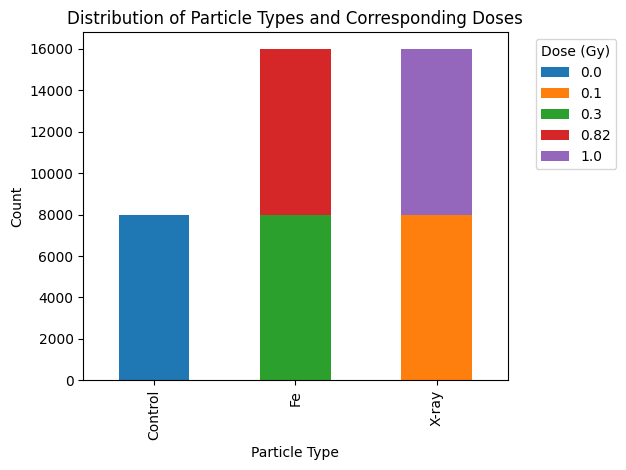

In [9]:
# Balancing classes and doses
# sample_size = 60000
# balanced_metadata = pd.DataFrame()

# Calculate the maximum number of samples per class combination
unique_dose_values = metadata['dose_Gy'].unique()
unique_particle_types = metadata['particle_type'].unique()
max_samples_per_class = sample_size // (len(unique_dose_values) * len(unique_particle_types))

for dose in unique_dose_values:
    for particle_type in unique_particle_types:
        subset = metadata[(metadata['dose_Gy'] == dose) & (metadata['particle_type'] == particle_type)]
        if len(subset) > max_samples_per_class:
            subset = subset.sample(max_samples_per_class)
        balanced_metadata = pd.concat([balanced_metadata, subset])

# Shuffle the balanced dataset
balanced_metadata = balanced_metadata.sample(frac=1).reset_index(drop=True)

# Plot a bar graph for each type and their corresponding dose
plt.figure(figsize=(12, 6))
ax = balanced_metadata.groupby(['particle_type', 'dose_Gy']).size().unstack().plot(kind='bar', stacked=True)
plt.title('Distribution of Particle Types and Corresponding Doses')
plt.xlabel('Particle Type')
plt.ylabel('Count')
plt.legend(title='Dose (Gy)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define input shape for the image
input_shape = (256, 256, 1)  # Assuming grayscale images

# Build the model
inputs = tf.keras.Input(shape=input_shape, name='image_input')

# Base Convolutional Layers (shared)
x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(256, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)

# Flatten the output of the conv layers
x = layers.Flatten()(x)

# Shared Dense Layer
x = layers.Dense(128, activation='relu')(x)

# Classification Head for particle type (iron, control, x-ray)
particle_output = layers.Dense(3, activation='softmax', name='particle_output')(x)

# Regression Head for dose (continuous value)
dose_output = layers.Dense(1, activation='linear', name='dose_output')(x)

# Build the model with two outputs
model = models.Model(inputs=inputs, outputs=[particle_output, dose_output])

# Compile the model with two loss functions and appropriate metrics
model.compile(optimizer='adam',
              loss={'dose_output': 'mean_squared_error',  # For continuous dose prediction
                    'particle_output': 'sparse_categorical_crossentropy'},  # For particle type classification
              metrics={'dose_output': 'mae',  # Mean Absolute Error for regression
                       'particle_output': 'accuracy'})  # Accuracy for classification

# Model summary
model.summary()


# # Train the model
# history = model.fit(train_dataset, validation_data=val_dataset, epochs=10, steps_per_epoch=train_size // 32, validation_steps=(len(balanced_metadata) - train_size) // 32)

# # Evaluate the model
# results = model.evaluate(val_dataset, steps=(len(balanced_metadata) - train_size) // 32)
# print("Test loss, Test MAE, Test Accuracy:", results)

# Train the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=20, 
                    steps_per_epoch=train_size // 32, 
                    validation_steps=(len(balanced_metadata) - train_size) // 32)

# Evaluate the model
results = model.evaluate(val_dataset, steps=(len(balanced_metadata) - train_size) // 32)
print("Test loss, Test MAE, Test Accuracy:", results)




Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 254, 254,  │        320 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 127, 127,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 125, 125,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 62, 62,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 60, 60,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 30, 30,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 28, 28,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 14, 14,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 50176)     │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │  6,422,656 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ particle_output     │ (None, 3)         │        387 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dose_output (Dense) │ (None, 1)         │        129 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,811,012 (25.98 MB)

 Trainable params: 6,811,012 (25.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1393s 3s/step - dose_output_mae: 0.3667 - loss: 1.1988 - particle_output_accuracy: 0.4714 - val_dose_output_mae: 0.3416 - val_loss: 1.0457 - val_particle_output_accuracy: 0.5695
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 663s 1s/step - dose_output_mae: 0.3409 - loss: 1.0171 - particle_output_accuracy: 0.5925 - val_dose_output_mae: 0.3426 - val_loss: 0.9796 - val_particle_output_accuracy: 0.6221
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 649s 1s/step - dose_output_mae: 0.3338 - loss: 0.9570 - particle_output_accuracy: 0.6240 - val_dose_output_mae: 0.3261 - val_loss: 0.9374 - val_particle_output_accuracy: 0.6320
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 653s 1s/step - dose_output_mae: 0.3304 - loss: 0.9312 - particle_output_accuracy: 0.6391 - val_dose_output_mae: 0.3180 - val_loss: 0.8935 - val_particle_output_accuracy: 0.6540
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 640s 1s/step - dose_output_mae: 0.3238 - loss: 0.8966 - particle_output_accuracy: 0.6556 - 

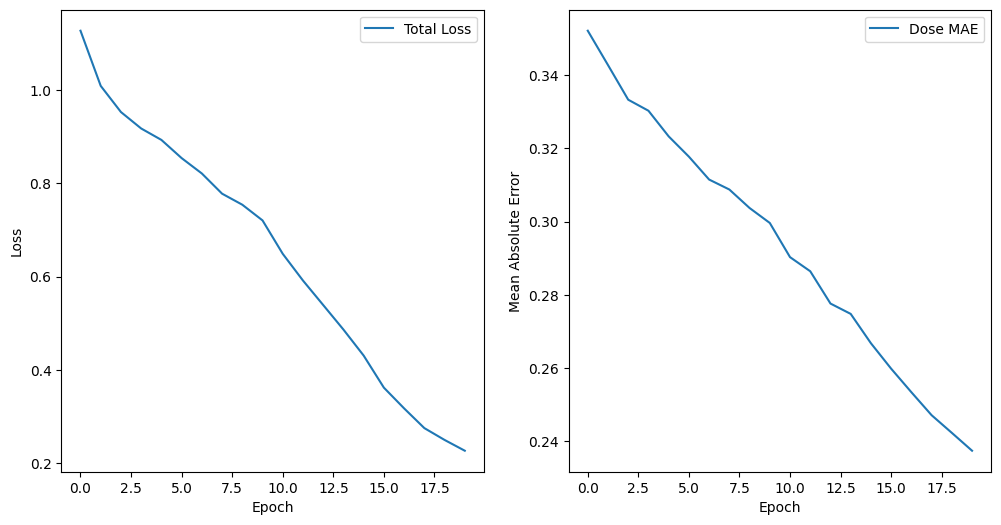

In [11]:
# Plot training history
plt.figure(figsize=(12, 6))

# Plot overall loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot MAE for each output
plt.subplot(1, 2, 2)
plt.plot(history.history['dose_output_mae'], label='Dose MAE')
# plt.plot(history.history['particle_output_accuracy'], label='Particle MAE')
# plt.plot(history.history['hr_output_mae'], label='HR MAE')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.show()


In [15]:
import cv2
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, accuracy_score

# Initialize lists to store results
true_dose = []
pred_dose = []  # Ensure this is a Python list
true_particle = []
pred_particle = []

# Load the image from the randomly selected sample
image_path = random_sample['filepath'].values[0]
true_dose_value = random_sample['dose_Gy'].values[0]
true_particle_value = random_sample['particle_type_encoded'].values[0]

# Load and process the selected image
image = load_image(image_path)

# Expand the dimensions to match the model input (batch size 1)
image = tf.expand_dims(image, axis=0)

# Run the image through the model to get predictions
predictions = model.predict(image)  # Only images are passed as input

# Extract predictions
pred_particle_probs, pred_dose = predictions  # Corrected: First output is particle type, second is dose

# Get the predicted particle type (class with highest probability)
predicted_particle = tf.argmax(pred_particle_probs, axis=1).numpy()[0]  # Predicted class index (particle type)

# Convert predicted dose to scalar (first value in the batch)
pred_dose_value = float(pred_dose[0][0])

# Store the true and predicted values
true_dose = [true_dose_value]  # Reset the lists to have only one value
pred_dose = [pred_dose_value]  # Reset the lists to have only one value
true_particle = [true_particle_value]  # Reset the lists to have only one value
pred_particle = [predicted_particle]  # Reset the lists to have only one value

# Calculate performance metrics

# Mean Absolute Error for dose
dose_mae = mean_absolute_error(true_dose, pred_dose)
print(f'Dose MAE: {dose_mae}')

# Accuracy for particle type (Since we're using only one image, accuracy will be either 0 or 1)
particle_accuracy = accuracy_score(true_particle, pred_particle)
print(f'Particle Type Accuracy: {particle_accuracy}')

# Now print the actual and predicted values for the selected image
print(f"True Dose: {true_dose[0]}, Predicted Dose: {pred_dose[0]}")
print(f"True Particle Type: {true_particle[0]}, Predicted Particle Type: {pred_particle[0]}")

# Reverse particle type mapping to output actual particle type names
inverse_particle_type_mapping = {v: k for k, v in particle_type_mapping.items()}
print(f"Predicted Particle Type (Name): {inverse_particle_type_mapping[pred_particle[0]]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Dose MAE: 0.027200505137443542
Particle Type Accuracy: 1.0
True Dose: 0.0, Predicted Dose: 0.027200505137443542
True Particle Type: 2, Predicted Particle Type: 2
Predicted Particle Type (Name): Control


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step


2024-10-25 11:56:46.663981: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


<Figure size 1200x600 with 0 Axes>

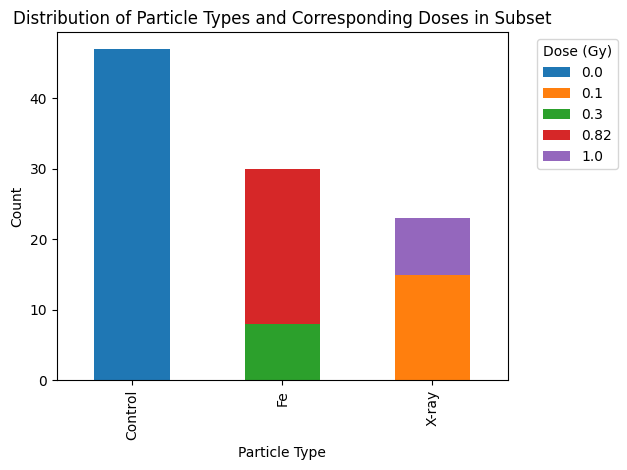

,Sample,Actual Dose,Predicted Dose,Actual Particle Type,Predicted Particle Type
0,1,0.00,0.412329,Control,Control
1,2,0.00,0.197719,Control,Fe
2,3,0.00,0.080059,Control,Control
3,4,0.30,0.319178,Fe,Fe
4,5,0.00,0.038245,Control,X-ray
5,6,0.30,0.524133,Fe,Fe
6,7,0.82,0.668580,Fe,X-ray
7,8,0.00,0.297081,Control,X-ray
8,9,0.00,0.344632,Control,X-ray
9,10,0.10,-0.244484,X-ray,X-ray


In [32]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ensure full display of DataFrame in output
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # No fixed width
pd.set_option('display.max_colwidth', None)  # No column width truncation

# Define the non-training metadata (from the earlier code)
# non_train_metadata already exists

# Sample 100 images from the non-training metadata
subset_metadata = non_train_metadata.sample(n=100)

# Create a TensorFlow Dataset from the sampled DataFrame
test_dataset = tf.data.Dataset.from_tensor_slices((
    tf.constant(subset_metadata['filepath'].values, dtype=tf.string),
    tf.constant(subset_metadata['dose_Gy'].values, dtype=tf.float32),
    tf.constant(subset_metadata['particle_type_encoded'].values, dtype=tf.int32)  # Use the encoded integer values
))

# Define load_data_wrapper or re-use the one defined earlier
test_dataset = test_dataset.map(load_data_wrapper).batch(32)

# Predict on the test dataset
predictions = model.predict(test_dataset)

# Reverse particle type mapping for display purposes
inverse_particle_type_mapping = {v: k for k, v in particle_type_mapping.items()}

# Initialize lists to store actual and predicted values
actual_doses = []
actual_particles = []

# Iterate through the test dataset to get actual values
for data in test_dataset:
    actual_doses.extend(data[1]['dose_output'].numpy())
    actual_particles.extend(data[1]['particle_output'].numpy())

# Prepare data for DataFrame
data_list = []
for i, (pred_particle_probs, pred_dose) in enumerate(zip(predictions[0], predictions[1])):  # Assuming predictions[0] = particle probs, predictions[1] = doses
    actual_dose = actual_doses[i].item()
    actual_particle = inverse_particle_type_mapping[int(actual_particles[i])]  # Reverse map the particle type
    
    # Predicted particle type: take the argmax of the softmax probabilities
    predicted_particle = inverse_particle_type_mapping[np.argmax(pred_particle_probs)]  # Get the predicted particle type

    # Predicted dose: it's already a scalar, no need to convert
    predicted_dose = float(pred_dose[0])  # Extract the scalar dose value

    # Append the results to the data list
    data_list.append({
        'Sample': i + 1,
        'Actual Dose': actual_dose,
        'Predicted Dose': predicted_dose,
        'Actual Particle Type': actual_particle,
        'Predicted Particle Type': predicted_particle
    })

# Create DataFrame
results_df = pd.DataFrame(data_list)


# Optionally, save DataFrame to an Excel file (uncomment if needed)
# results_df.to_excel('results_100_images.xlsx', index=False)

# Now let's plot the distribution of particle types and their corresponding doses
# Plot a bar graph for each type and their corresponding dose
plt.figure(figsize=(12, 6))
ax = subset_metadata.groupby(['particle_type', 'dose_Gy']).size().unstack().plot(kind='bar', stacked=True)
plt.title('Distribution of Particle Types and Corresponding Doses in Subset')
plt.xlabel('Particle Type')
plt.ylabel('Count')
plt.legend(title='Dose (Gy)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Display the full DataFrame without truncation
results_df[:10]

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step
Mean Absolute Error (Dose): 0.31256410881876945
Particle Type Accuracy: 0.57


2024-10-25 12:13:41.012220: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


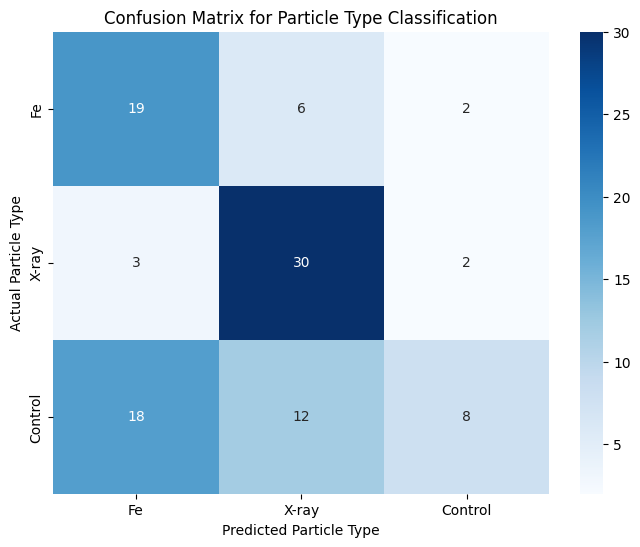

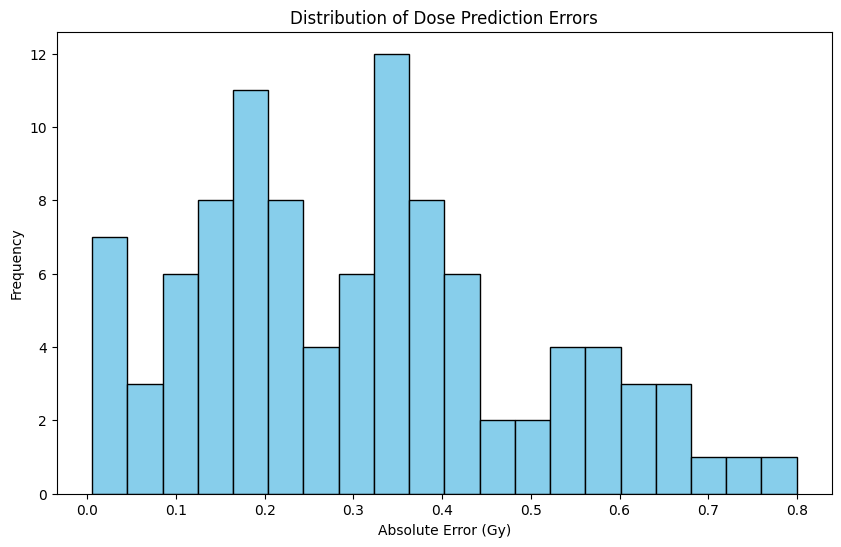

In [43]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define the non-training metadata (from the earlier code)
# non_train_metadata already exists

# Sample 100 images from the non-training metadata
subset_metadata = non_train_metadata.sample(n=100)

# Create a TensorFlow Dataset from the sampled DataFrame
test_dataset = tf.data.Dataset.from_tensor_slices((
    tf.constant(subset_metadata['filepath'].values, dtype=tf.string),
    tf.constant(subset_metadata['dose_Gy'].values, dtype=tf.float32),
    tf.constant(subset_metadata['particle_type_encoded'].values, dtype=tf.int32)  # Use the encoded integer values
))

# Define load_data_wrapper or re-use the one defined earlier
test_dataset = test_dataset.map(load_data_wrapper).batch(32)

# Predict on the test dataset
predictions = model.predict(test_dataset)

# Reverse particle type mapping for display purposes
inverse_particle_type_mapping = {v: k for k, v in particle_type_mapping.items()}

# Initialize lists to store actual and predicted values
actual_doses = []
actual_particles = []
predicted_doses = []
predicted_particles = []

# Iterate through the test dataset to get actual and predicted values
for data in test_dataset:
    actual_doses.extend(data[1]['dose_output'].numpy())
    actual_particles.extend(data[1]['particle_output'].numpy())

# Extract predictions from the model outputs
for i, (pred_particle_probs, pred_dose) in enumerate(zip(predictions[0], predictions[1])):
    predicted_particle = np.argmax(pred_particle_probs)  # Predicted particle type
    predicted_dose = float(pred_dose[0])  # Predicted dose value

    # Store predictions
    predicted_particles.append(predicted_particle)
    predicted_doses.append(predicted_dose)

# Calculate performance metrics

# Mean Absolute Error for dose
dose_mae = mean_absolute_error(actual_doses, predicted_doses)
print(f'Mean Absolute Error (Dose): {dose_mae}')

# Accuracy for particle type
particle_accuracy = accuracy_score(actual_particles, predicted_particles)
print(f'Particle Type Accuracy: {particle_accuracy}')

# Create a confusion matrix for particle type classification
cm = confusion_matrix(actual_particles, predicted_particles)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=inverse_particle_type_mapping.values(),
            yticklabels=inverse_particle_type_mapping.values())
plt.xlabel('Predicted Particle Type')
plt.ylabel('Actual Particle Type')
plt.title('Confusion Matrix for Particle Type Classification')
plt.show()

# Plot the distribution of dose prediction errors
dose_errors = np.abs(np.array(actual_doses) - np.array(predicted_doses))
plt.figure(figsize=(10, 6))
plt.hist(dose_errors, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Dose Prediction Errors')
plt.xlabel('Absolute Error (Gy)')
plt.ylabel('Frequency')
plt.show()


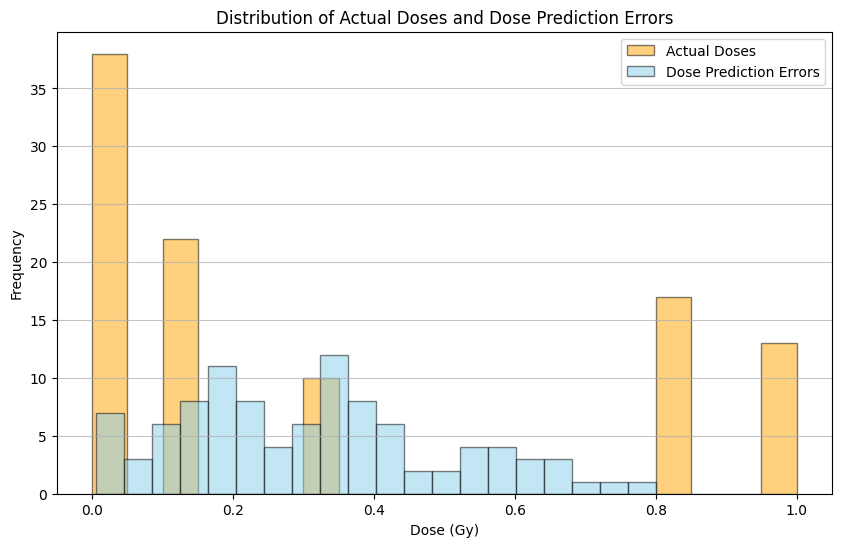

In [44]:
# Calculate dose prediction errors
dose_errors = np.abs(np.array(actual_doses) - np.array(predicted_doses))

# Create histograms for dose errors and actual doses
plt.figure(figsize=(10, 6))

# Plot histogram for actual doses
plt.hist(actual_doses, bins=20, alpha=0.5, color='orange', label='Actual Doses', edgecolor='black')

# Plot histogram for dose prediction errors
plt.hist(dose_errors, bins=20, alpha=0.5, color='skyblue', label='Dose Prediction Errors', edgecolor='black')

# Adding labels and title
plt.title('Distribution of Actual Doses and Dose Prediction Errors')
plt.xlabel('Dose (Gy)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', alpha=0.75)

# Show the plot
plt.show()


In [45]:
import pandas as pd
import numpy as np

# Create a DataFrame to store all relevant information
results_df = pd.DataFrame({
    'Actual Dose (Gy)': actual_doses,
    'Predicted Dose (Gy)': predicted_doses,
    'Dose Error (Gy)': dose_errors,
    'Actual Particle Type': [inverse_particle_type_mapping[ptype] for ptype in actual_particles],
    'Predicted Particle Type': [inverse_particle_type_mapping[ptype] for ptype in predicted_particles]
})

# Sort the DataFrame by the dose error in ascending order to display the most accurate predictions at the top
sorted_results_df = results_df.sort_values(by='Dose Error (Gy)', ascending=True).reset_index(drop=True)

# Display the sorted DataFrame
display(sorted_results_df)


,Actual Dose (Gy),Predicted Dose (Gy),Dose Error (Gy),Actual Particle Type,Predicted Particle Type
0,0.10,0.105467,0.005467,X-ray,X-ray
1,0.10,0.082018,0.017982,X-ray,X-ray
2,0.10,0.072599,0.027401,X-ray,X-ray
3,0.10,0.128979,0.028979,X-ray,X-ray
4,1.00,1.033123,0.033123,X-ray,X-ray
5,0.30,0.337544,0.037544,Fe,Fe
6,0.10,0.059539,0.040461,X-ray,X-ray
7,0.82,0.755294,0.064706,Fe,Fe
8,0.10,0.018386,0.081614,X-ray,X-ray
9,0.30,0.382351,0.082351,Fe,Fe


In [48]:
# Create a DataFrame with file paths included
results_df = pd.DataFrame({
    'Filepath': subset_metadata['filepath'].values,
    'Actual Dose (Gy)': actual_doses,
    'Predicted Dose (Gy)': predicted_doses,
    'Dose Error (Gy)': dose_errors,
    'Actual Particle Type': [inverse_particle_type_mapping[ptype] for ptype in actual_particles],
    'Predicted Particle Type': [inverse_particle_type_mapping[ptype] for ptype in predicted_particles]
})

# Sort the DataFrame by the dose error in ascending order to display the most accurate predictions at the top
sorted_results_df = results_df.sort_values(by='Dose Error (Gy)', ascending=True).reset_index(drop=True)

# Find the best-performing entry (the first one in the sorted DataFrame)
best_performing_entry = sorted_results_df.iloc[0]

# Display the best-performing entry's details
print("Best Performing Entry Details:")
display(best_performing_entry)

# Extract and display the filepath of the best-performing entry
best_filepath = best_performing_entry['Filepath']
print(f'The filepath of the best-performing entry is: {best_filepath}')

# Find the worst-performing entry (the last one in the sorted DataFrame)
worst_performing_entry = sorted_results_df.iloc[-1]

# Display the worst-performing entry's details
print("\nWorst Performing Entry Details:")
display(worst_performing_entry)

# Extract and display the filepath of the worst-performing entry
worst_filepath = worst_performing_entry['Filepath']
print(f'The filepath of the worst-performing entry is: {worst_filepath}')


Best Performing Entry Details:


Filepath                   BPS-Microscopy/train/P287_73668956345-F5_011_024_proj.tif
Actual Dose (Gy)                                                                 0.1
Predicted Dose (Gy)                                                         0.105467
Dose Error (Gy)                                                             0.005467
Actual Particle Type                                                           X-ray
Predicted Particle Type                                                        X-ray
Name: 0, dtype: object

The filepath of the best-performing entry is: BPS-Microscopy/train/P287_73668956345-F5_011_024_proj.tif

Worst Performing Entry Details:


Filepath                   BPS-Microscopy/train/P284_73668752578-F5_017_008_proj.tif
Actual Dose (Gy)                                                                 1.0
Predicted Dose (Gy)                                                         0.200304
Dose Error (Gy)                                                             0.799696
Actual Particle Type                                                           X-ray
Predicted Particle Type                                                        X-ray
Name: 99, dtype: object

The filepath of the worst-performing entry is: BPS-Microscopy/train/P284_73668752578-F5_017_008_proj.tif


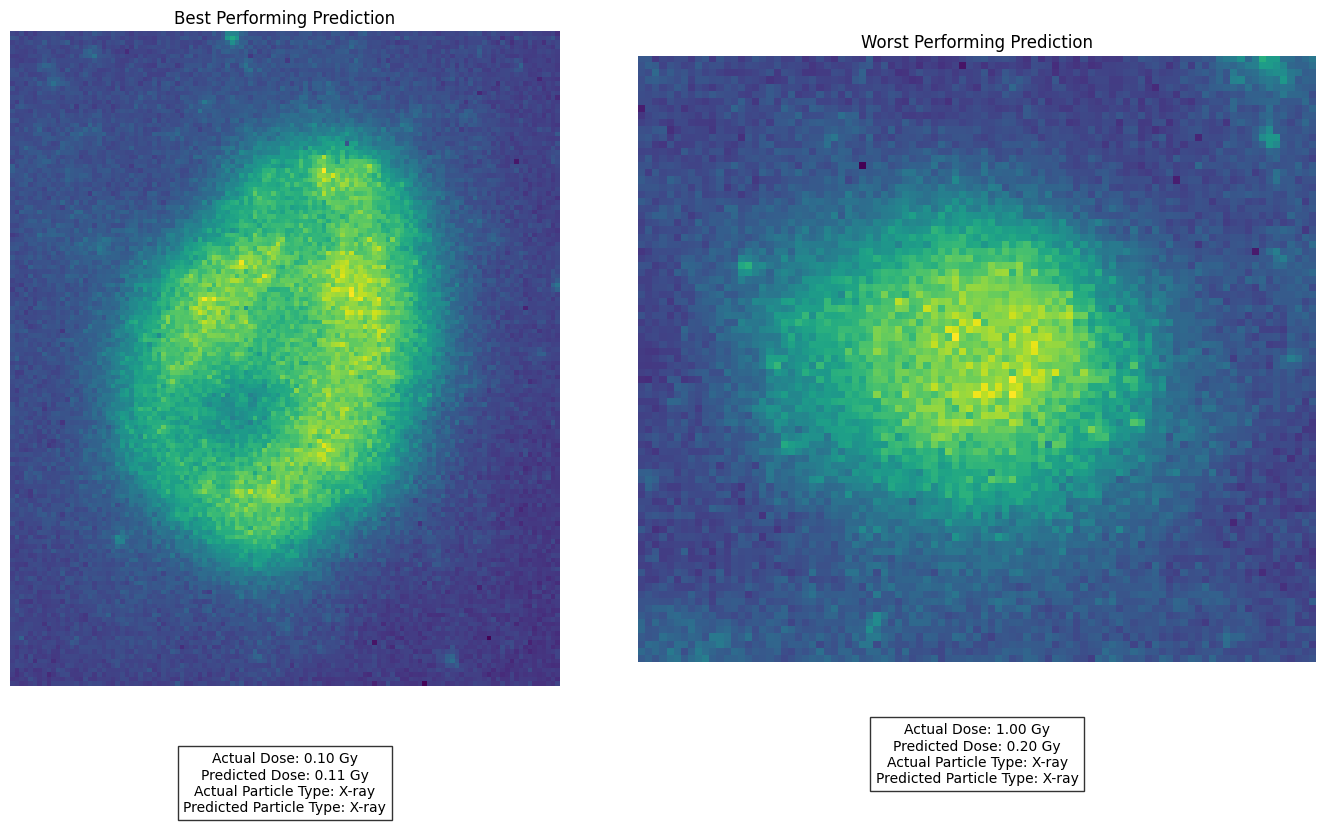

In [49]:
from PIL import Image
import matplotlib.pyplot as plt

# Get the file paths and corresponding results for the best and worst-performing entries
best_entry = sorted_results_df.iloc[0]
worst_entry = sorted_results_df.iloc[-1]

best_filepath = best_entry['Filepath']
worst_filepath = worst_entry['Filepath']

# Load and display the best-performing image
best_image = Image.open(best_filepath)
plt.figure(figsize=(14, 8))

# Plot the best-performing prediction
plt.subplot(1, 2, 1)
plt.imshow(best_image)
plt.title('Best Performing Prediction')
plt.axis('off')
plt.text(
    0.5, -0.1, 
    f"Actual Dose: {best_entry['Actual Dose (Gy)']:.2f} Gy\nPredicted Dose: {best_entry['Predicted Dose (Gy)']:.2f} Gy\n"
    f"Actual Particle Type: {best_entry['Actual Particle Type']}\nPredicted Particle Type: {best_entry['Predicted Particle Type']}",
    fontsize=10, color='black', ha='center', va='top', transform=plt.gca().transAxes,
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='black')
)

# Load and display the worst-performing image
worst_image = Image.open(worst_filepath)
plt.subplot(1, 2, 2)
plt.imshow(worst_image)
plt.title('Worst Performing Prediction')
plt.axis('off')
plt.text(
    0.5, -0.1, 
    f"Actual Dose: {worst_entry['Actual Dose (Gy)']:.2f} Gy\nPredicted Dose: {worst_entry['Predicted Dose (Gy)']:.2f} Gy\n"
    f"Actual Particle Type: {worst_entry['Actual Particle Type']}\nPredicted Particle Type: {worst_entry['Predicted Particle Type']}",
    fontsize=10, color='black', ha='center', va='top', transform=plt.gca().transAxes,
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='black')
)

plt.tight_layout()
plt.show()


In [21]:
# After training
model.save_weights('model.weights.h5')
print("Weights saved successfully.")


Weights saved successfully.


In [ ]:
# # Assuming you have the same model architecture defined as 'model'
# model.load_weights('model.weights.h5')
# print("Weights loaded successfully.")


<Figure size 1200x600 with 0 Axes>

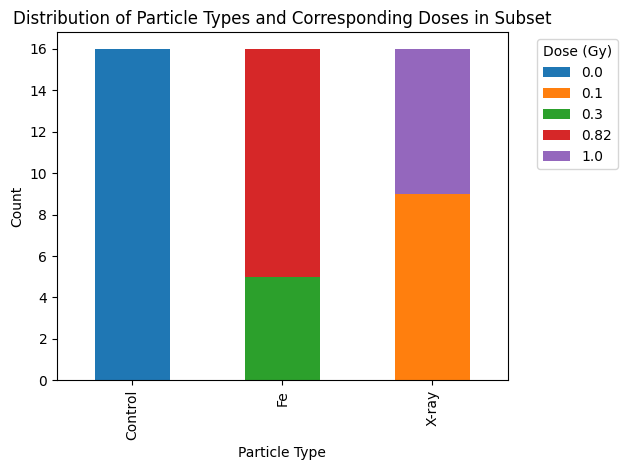

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


2024-07-05 17:00:58.155961: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


,Sample,Actual Dose,Predicted Dose,Actual Particle Type,Predicted Particle Type
0,1,0.82,0.810977,Fe,Fe
1,2,0.30,0.367726,Fe,Fe
2,3,0.30,0.367132,Fe,Fe
3,4,0.82,0.792185,Fe,Fe
4,5,0.82,0.830840,Fe,Fe
5,6,0.82,0.812612,Fe,Fe
6,7,0.82,0.795110,Fe,Fe
7,8,0.30,0.353314,Fe,Fe
8,9,0.82,0.837543,Fe,Fe
9,10,0.82,0.848056,Fe,Fe


In [15]:
# Define the paths
image_folder = 'BPS-Microscopy/DAPI_MASK_images'
meta_csv_path = 'BPS-Microscopy/DAPI_MASK_images/meta_DAPI_MASK.csv'

# Load the metadata CSV
metadata = pd.read_csv(meta_csv_path)

# Set particle_type to 'Control' where dose_Gy is 0
metadata.loc[metadata['dose_Gy'] == 0, 'particle_type'] = 'Control'

# Filter the DataFrame to include only files ending with "_DAPI.tif"
metadata['filepath'] = image_folder + '/' + metadata['filename']
filtered_metadata = metadata[metadata['filename'].str.endswith('_DAPI.tif')]

# Sample an equal number of images from each particle type
particle_types = ['Fe', 'X-ray', 'Control']
samples_per_type = 50 // len(particle_types)
subset_metadata = pd.concat([
    filtered_metadata[filtered_metadata['particle_type'] == pt].sample(samples_per_type, random_state=42)
    for pt in particle_types
])

# Plot a bar graph for each type and their corresponding dose
plt.figure(figsize=(12, 6))
ax = subset_metadata.groupby(['particle_type', 'dose_Gy']).size().unstack().plot(kind='bar', stacked=True)
plt.title('Distribution of Particle Types and Corresponding Doses in Subset')
plt.xlabel('Particle Type')
plt.ylabel('Count')
plt.legend(title='Dose (Gy)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Create a TensorFlow Dataset from the sampled DataFrame
test_dataset = tf.data.Dataset.from_tensor_slices((
    tf.constant(subset_metadata['filepath'].values, dtype=tf.string),
    tf.constant(subset_metadata['dose_Gy'].values, dtype=tf.float32),
    tf.constant(subset_metadata['particle_type'].values, dtype=tf.string)
))
test_dataset = test_dataset.map(load_data_wrapper).batch(32)

# Predict on the test dataset
predictions = model.predict(test_dataset)

# Display predictions and actual values
particle_type_mapping = {'Fe': 0, 'X-ray': 1, 'Control': 2}
inverse_particle_type_mapping = {v: k for k, v in particle_type_mapping.items()}

# Iterate through the test dataset to get actual values
actual_doses = []
actual_particles = []
for data in test_dataset:
    actual_doses.extend(data[1]['dose_output'].numpy())
    actual_particles.extend(data[1]['particle_output'].numpy())

# Prepare data for DataFrame
data_list = []
for i, (pred_dose, pred_particle) in enumerate(zip(predictions[0], predictions[1])):
    actual_dose = actual_doses[i].item()
    actual_particle = inverse_particle_type_mapping[int(actual_particles[i])]
    predicted_dose = pred_dose.item()
    predicted_particle = inverse_particle_type_mapping[np.argmax(pred_particle)]
    
    data_list.append({
        'Sample': i + 1,
        'Actual Dose': actual_dose,
        'Predicted Dose': predicted_dose,
        'Actual Particle Type': actual_particle,
        'Predicted Particle Type': predicted_particle
    })

# Create DataFrame
results_df = pd.DataFrame(data_list)

# Save DataFrame to an Excel file
results_df.to_excel('results.xlsx', index=False)

# Display DataFrame
results_df

# Filter DataFrame by Actual Particle Type 'Fe'
# filtered_results_df = results_df[results_df['Actual Particle Type'] == 'Fe']

# Display Filtered DataFrame
# filtered_results_df

In [16]:
# Initialize lists to store results
true_dose = []
pred_dose = []
true_particle = []
pred_particle = []

# Iterate over the test dataset
for data in test_dataset:
    inputs, labels = data
    images = inputs['image_input']
    metadata = inputs['metadata_input']
    dose = labels['dose_output']
    particle_type = labels['particle_output']
    
    predictions = model.predict({'image_input': images, 'metadata_input': metadata})
    
    # Extract predictions
    pred_dose_batch, pred_particle_batch = predictions
    
    # Store the true values and predictions
    true_dose.extend(dose.numpy())
    pred_dose.extend(pred_dose_batch)
    true_particle.extend(particle_type.numpy())
    pred_particle.extend(tf.argmax(pred_particle_batch, axis=1).numpy())  # Get the predicted class

# Calculate performance metrics

# Mean Absolute Error for dose
dose_mae = mean_absolute_error(true_dose, pred_dose)
print(f'Dose MAE: {dose_mae}')

# Accuracy for particle type
particle_accuracy = accuracy_score(true_particle, pred_particle)
print(f'Particle Type Accuracy: {particle_accuracy}')

# Calculate performance metrics

# Mean Absolute Error for dose
dose_mae = mean_absolute_error(true_dose, pred_dose)
print(f'Dose MAE: {dose_mae}')

# Accuracy for particle type
particle_accuracy = accuracy_score(true_particle, pred_particle)
print(f'Particle Type Accuracy: {particle_accuracy}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
Dose MAE: 0.03679058700799942
Particle Type Accuracy: 1.0
Dose MAE: 0.03679058700799942
Particle Type Accuracy: 1.0


2024-07-05 17:01:37.013386: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [17]:
# Load the metadata CSV
meta_csv_path = 'BPS-Microscopy/DAPI_MASK_images/meta_DAPI_MASK.csv'
metadata = pd.read_csv(meta_csv_path)

# Set particle_type to 'Control' where dose_Gy is 0
metadata.loc[metadata['dose_Gy'] == 0, 'particle_type'] = 'Control'

# Add the full path to the filenames in the metadata
image_folder = 'BPS-Microscopy/DAPI_MASK_images'
metadata['filepath'] = image_folder + '/' + metadata['filename']

# Select the row corresponding to the specific image path
# image_path = 'BPS-Microscopy/DAPI_MASK_images/P251_73665707362-C7_003_004_DAPI.tif'
image_path = 'BPS-Microscopy/DAPI_MASK_images/P288_73669012104-F5_016_040_DAPI.tif'
selected_row = metadata[metadata['filepath'] == image_path].iloc[0]
print(f"Selected image: {image_path}")

# Get the actual values for comparison
actual_dose = selected_row['dose_Gy']
actual_particle_type = selected_row['particle_type']
actual_hr_post_exposure = selected_row['hr_post_exposure']

def preprocess_single_image(image_path):
    # Load the image using cv2
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    
    # Convert the image to a tensor
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    
    # Ensure the image has 3 dimensions (height, width, channels)
    if image.ndim == 2:
        image = tf.expand_dims(image, axis=-1)  # Add the channel dimension
    
    # Resize the image
    image = tf.image.resize(image, (256, 256))
    
    # Normalize the image to [0, 1]
    image = (image - tf.reduce_min(image)) / (tf.reduce_max(image) - tf.reduce_min(image))
    
    # Add a batch dimension
    image = tf.expand_dims(image, axis=0)
    
    return image

# Preprocess the selected image
preprocessed_image = preprocess_single_image(image_path)

# Prepare the metadata for the image
def preprocess_single_metadata(dose_Gy, particle_type):
    particle_type_mapping = {'Fe': 0, 'X-ray': 1, 'Control': 2}
    particle_type_encoded = particle_type_mapping[particle_type]
    max_dose = 1.0
    dose_Gy_normalized = dose_Gy / max_dose
    metadata_tensor = tf.convert_to_tensor([dose_Gy_normalized, particle_type_encoded], dtype=tf.float32)
    metadata_tensor = tf.expand_dims(metadata_tensor, axis=0)  # Add a batch dimension
    return metadata_tensor

preprocessed_metadata = preprocess_single_metadata(actual_dose, actual_particle_type)

# Assuming you have your trained model loaded as `model`
# model = ... (load your trained model)

# Make predictions
predictions = model.predict({'image_input': preprocessed_image, 'metadata_input': preprocessed_metadata})

# Extract predictions
pred_dose, pred_particle_type = predictions

# Convert predictions from arrays to scalars
pred_dose = pred_dose[0]
pred_particle_type = pred_particle_type[0]

# Convert particle type probabilities to percentages
pred_particle_type_percentages = [f"{p*100:.2f}%" for p in pred_particle_type]

# Get the predicted class for particle type
pred_particle_type_class = np.argmax(pred_particle_type)

# Class names for easier reading
particle_type_names = ['Control', 'X-ray', 'Fe']

# Print predictions in a readable format
print(f"\nPredicted Dose: {pred_dose}")
print(f"Predicted Particle Type Probabilities: {pred_particle_type_percentages}")
print(f"Predicted Particle Type: {particle_type_names[pred_particle_type_class]}")

# Compare with actual values
print(f"\nActual Dose: {actual_dose}")
print(f"Actual Particle Type: {actual_particle_type}")
# print(f"Actual Hours Post-Exposure: {actual_hr_post_exposure}")


Selected image: BPS-Microscopy/DAPI_MASK_images/P288_73669012104-F5_016_040_DAPI.tif
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step

Predicted Dose: [0.98502827]
Predicted Particle Type Probabilities: ['1.76%', '97.77%', '0.47%']
Predicted Particle Type: X-ray

Actual Dose: 1.0
Actual Particle Type: X-ray


filename: P288_73669012104-F5_016_040_DAPI.tif
is_tiled: False
is_bigtiff: False
shape: (134, 183)
dtype: uint16
compression: COMPRESSION.NONE
photometric: PHOTOMETRIC.MINISBLACK
bits_per_sample: 16
Software: DIPlib with dipIO
ResolutionUnit: 2
XResolution: (1, 1)
YResolution: (1, 1)
tags: {'ImageWidth': 183, 'ImageLength': 134, 'BitsPerSample': 16, 'Compression': <COMPRESSION.NONE: 1>, 'PhotometricInterpretation': <PHOTOMETRIC.MINISBLACK: 1>, 'StripOffsets': (8, 8060, 16112, 24164, 32216, 40268, 48320), 'RowsPerStrip': 22, 'StripByteCounts': (8052, 8052, 8052, 8052, 8052, 8052, 732), 'PlanarConfiguration': <PLANARCONFIG.CONTIG: 1>, 'SampleFormat': <SAMPLEFORMAT.UINT: 1>}
number_of_pages: 1


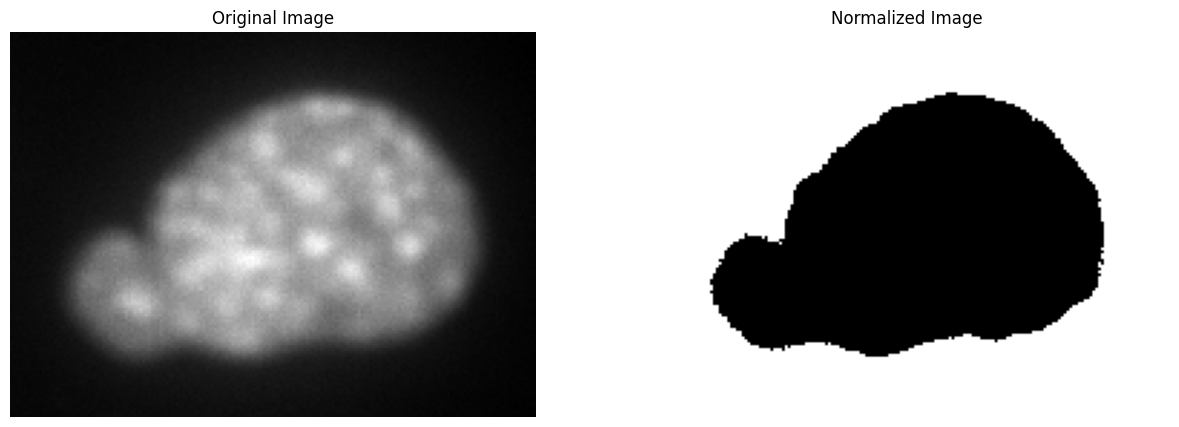

In [18]:
def get_image_metadata(image_path):
    with tiff.TiffFile(image_path) as tif:
        image_metadata = {}
        image_metadata['filename'] = tif.filename
        image_metadata['is_tiled'] = any(page.is_tiled for page in tif.pages)
        image_metadata['is_bigtiff'] = tif.is_bigtiff
        
        # Extract metadata from the first page
        page = tif.pages[0]
        image_metadata['shape'] = page.shape
        image_metadata['dtype'] = page.dtype.name
        
        # Extract compression, photometric, and bits per sample if they exist
        if hasattr(page, 'compression'):
            image_metadata['compression'] = str(page.compression)
        if hasattr(page, 'photometric'):
            image_metadata['photometric'] = str(page.photometric)
        if hasattr(page, 'bitspersample'):
            image_metadata['bits_per_sample'] = page.bitspersample
        else:
            # Use tags to get bits per sample if not directly available
            if 'BitsPerSample' in page.tags:
                image_metadata['bits_per_sample'] = page.tags['BitsPerSample'].value
        
        # Check for common tags
        common_tags = ['ImageDescription', 'Artist', 'Software', 'DateTime', 'ResolutionUnit', 'XResolution', 'YResolution']
        for tag in common_tags:
            if tag in page.tags:
                image_metadata[tag] = page.tags[tag].value
        
        # Collect all other tags
        image_metadata['tags'] = {tag.name: tag.value for tag in page.tags.values() if tag.name not in common_tags}

        # Multipage TIFF info
        image_metadata['number_of_pages'] = len(tif.pages)

        return image_metadata

# Example usage
image_path = 'BPS-Microscopy/DAPI_MASK_images/P288_73669012104-F5_016_040_DAPI.tif'
metadata = get_image_metadata(image_path)
for key, value in metadata.items():
    print(f'{key}: {value}')


# Function to read and preprocess the TIFF image
def preprocess_image(image_path):
    # Read the image using tifffile
    image = tiff.imread(image_path)
    # Normalize the image to improve visibility
    normalized_image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    # Flatten the image for clustering
    flat_image = normalized_image.flatten().reshape(-1, 1)
    return image, flat_image, normalized_image

# Function to apply K-means clustering to the image
def apply_kmeans(flat_image, n_clusters=2):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(flat_image)
    clustered = kmeans.labels_
    return clustered

# Function to visualize the clustered image
def visualize_clusters(image, clustered, n_clusters):
    # Reshape the clustered labels back to the original image shape
    clustered_image = clustered.reshape(image.shape)
    # Create a colored version of the clustered image for better visibility
    colored_clustered_image = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    colors = np.linspace(0, 255, n_clusters).astype(np.uint8)
    for i in range(n_clusters):
        colored_clustered_image[clustered_image == i] = [colors[i]] * 3
    return colored_clustered_image

# Main function to process the image and detect foci
def detect_foci(image_path, n_clusters=2):
    image, flat_image, normalized_image = preprocess_image(image_path)
    clustered = apply_kmeans(flat_image, n_clusters)
    segmented_image = visualize_clusters(image, clustered, n_clusters)
    
    # Display the original, normalized, and segmented images
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title('Normalized Image')
    plt.imshow(segmented_image, cmap='gray')
    plt.axis('off')
    
    # plt.subplot(1, 3, 3)
    # plt.title('Segmented Image')
    # plt.imshow(segmented_image)
    # plt.axis('off')
    
    plt.show()

# Example usage
# image_path = 'BPS-Microscopy/train/P244_73665165741-C8_017_024_proj.tif'
image_path = 'BPS-Microscopy/DAPI_MASK_images/P288_73669012104-F5_016_040_DAPI.tif'
# image_path = 'BPS-Microscopy/DAPI_MASK_images/P251_73665707362-C7_002_010_DAPI.tif'
detect_foci(image_path, n_clusters=2)

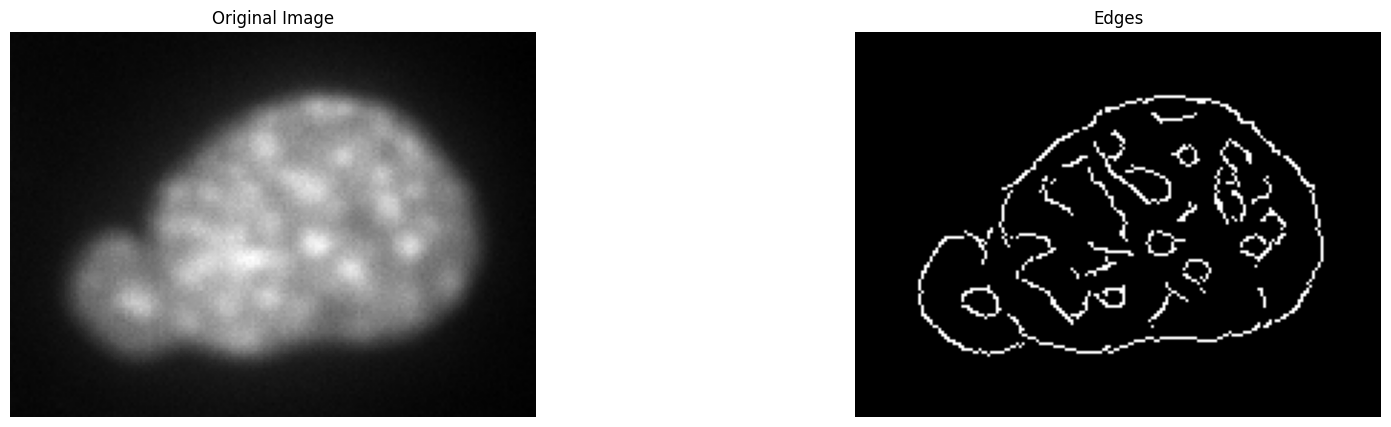

In [19]:
# Function to read and preprocess the TIFF image
def preprocess_image(image_path):
    # Read the image using tifffile
    image = tiff.imread(image_path)
    # Normalize the image to improve visibility
    normalized_image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    return normalized_image

# Function to apply Otsu's thresholding and count foci
def count_foci_otsu_with_edges(image_path):
    image = preprocess_image(image_path)
    
    # Apply GaussianBlur to reduce noise and improve thresholding
    blurred_image = cv2.GaussianBlur(image, (7, 7), 0)
    
    # Apply Canny edge detection with adjusted thresholds
    edges = cv2.Canny(blurred_image, 25, 75)
    
    # Combine edges with the original image
    combined = cv2.addWeighted(blurred_image, 0.5, edges, 0.5, 0)
    
    # Apply Otsu's thresholding
    _, binary_image = cv2.threshold(combined, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Invert the binary image to make foci white and background black
    binary_image = cv2.bitwise_not(binary_image)
    
    # Apply morphological operations to separate overlapping foci with adjusted kernel size and iterations
    kernel = np.ones((3, 3), np.uint8)
    morphed_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel, iterations=3)
    morphed_image = cv2.morphologyEx(morphed_image, cv2.MORPH_CLOSE, kernel, iterations=3)
    morphed_image = cv2.erode(morphed_image, kernel, iterations=2)
    
    # Find connected components
    num_labels, labels_im = cv2.connectedComponents(morphed_image)
    
    # Plot the original, edges, binary, and labeled images
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    plt.title('Original Image')
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title('Edges')
    plt.imshow(edges, cmap='gray')
    plt.axis('off')
    
    # plt.subplot(1, 3, 3)
    # plt.title('Binary Image')
    # plt.imshow(binary_image, cmap='gray')
    # plt.axis('off')
    
    # plt.subplot(1, 4, 4)
    # plt.title('Labeled Image')
    # plt.imshow(labels_im, cmap='nipy_spectral')
    # plt.axis('off')
    
    plt.show()
    
    # Return the count of foci (subtracting 1 for the background)
    return num_labels - 1

# Example usage
image_path = 'BPS-Microscopy/DAPI_MASK_images/P288_73669012104-F5_016_040_DAPI.tif'
num_foci = count_foci_otsu_with_edges(image_path)
# print(f'Number of foci detected: {num_foci}')


[1502 2998]


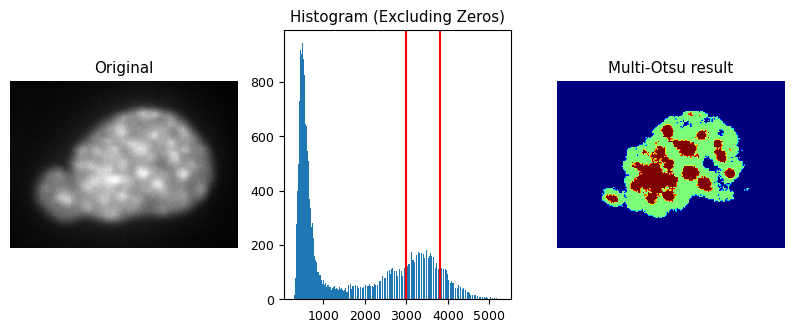

In [20]:
# Setting the font size for all plots.
matplotlib.rcParams['font.size'] = 9

# Load the image (assuming preprocess_image is defined elsewhere)
# image_path = 'BPS-Microscopy/DAPI_MASK_images/P288_73669012104-F5_016_040_DAPI.tif'
masked_image = tiff.imread(image_path)

# Applying multi-Otsu threshold for the default value, generating three classes
thresholds = threshold_multiotsu(masked_image)
print(thresholds)
thresholds =[3000, 3800]

# Using the threshold values, generate the three regions
regions = np.digitize(masked_image, bins=thresholds)

# Filter out zero values for histogram plotting
non_zero_masked_image = masked_image[masked_image > 0]

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))

# Plot the original image
ax[0].imshow(masked_image, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

# Plot the histogram and the two thresholds obtained from multi-Otsu
ax[1].hist(non_zero_masked_image.ravel(), bins=255)
ax[1].set_title('Histogram (Excluding Zeros)')
for thresh in thresholds:
    ax[1].axvline(thresh, color='r')

# Plot the Multi-Otsu result
ax[2].imshow(regions, cmap='jet')
ax[2].set_title('Multi-Otsu result')
ax[2].axis('off')

plt.subplots_adjust()
plt.show()


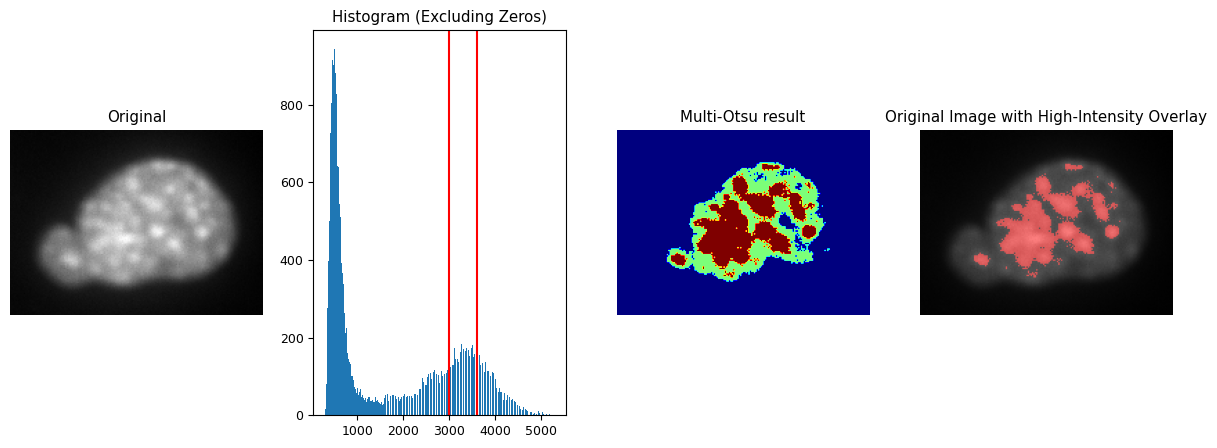

In [21]:
# Setting the font size for all plots.
matplotlib.rcParams['font.size'] = 9

# Load the image
image_path = 'BPS-Microscopy/DAPI_MASK_images/P288_73669012104-F5_016_040_DAPI.tif'
image = tiff.imread(image_path)

# Applying multi-Otsu threshold for the default value, generating three classes
thresholds = threshold_multiotsu(masked_image)
thresholds =[3000, 3600]

# Using the threshold values, generate the three regions
regions = np.digitize(masked_image, bins=thresholds)

# Filter out zero values for histogram plotting
non_zero_masked_image = masked_image[masked_image > 0]

# Custom colormap for red overlay
red_cmap = LinearSegmentedColormap.from_list('red_cmap', ['black', 'red'], N=256)

# Create an overlay where the highest intensity regions are shown
high_intensity_overlay = (regions == 2).astype(np.uint16)

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15, 5))

# Plot the original image
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

# Plot the histogram and the two thresholds obtained from multi-Otsu
ax[1].hist(non_zero_masked_image.ravel(), bins=255)
ax[1].set_title('Histogram (Excluding Zeros)')
for thresh in thresholds:
    ax[1].axvline(thresh, color='r')

# Plot the Multi-Otsu result
ax[2].imshow(regions, cmap='jet')
ax[2].set_title('Multi-Otsu result')
ax[2].axis('off')

# Plot the Multi-Otsu result
ax[3].imshow(image, cmap='gray')
ax[3].imshow(high_intensity_overlay, cmap=red_cmap, alpha=0.5)
ax[3].set_title('Original Image with High-Intensity Overlay')
ax[3].axis('off')

plt.subplots_adjust()
plt.show()
